In [1]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras import Input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy, sparse_categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from matplotlib.pyplot import figure
from skimage.io import imshow
from tensorflow.keras.layers import BatchNormalization

def unet(input_size = (2048,2048,4), filters=64, blocks=4):
    encoder = []
    inputs = Input(input_size)
    prev = inputs
    for i in range(blocks):
        cur = Conv2D(filters=filters, kernel_size=3, padding = 'same', kernel_initializer = 'he_normal')(prev)
        cur = BatchNormalization()(cur)
        cur = Activation(relu)(cur)

        cur = Conv2D(filters=filters, kernel_size=3, padding = 'same', kernel_initializer = 'he_normal')(cur)
        cur = BatchNormalization()(cur)
        cur = Activation(relu)(cur)

        encoder.append(cur)

        cur = MaxPooling2D()(cur)

        filters *= 2
        prev = cur

    for i in range(blocks - 1, -1, -1):
        cur = UpSampling2D()(prev)
        cur = Conv2D(filters=filters, kernel_size=3, padding='same')(cur)
        cur = Activation(relu)(cur)
        cur = concatenate([cur, encoder[i]], axis=3)

        cur = Conv2D(filters=filters, kernel_size=3, padding='same')(cur)
        cur = Activation(relu)(cur)
        cur = Conv2D(filters=filters, kernel_size=3, padding='same')(cur)
        cur = Activation(relu)(cur)

        prev = cur
        filters //= 2

    prev = Conv2D(1, kernel_size=1)(prev)
    prev = Activation(sigmoid)(prev)

    
    model = Model(inputs=inputs, outputs=prev)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model


Using TensorFlow backend.


In [0]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [0]:
import numpy as np 
import random as rnd
from matplotlib import pyplot as plt
from skimage.draw import circle
from skimage.io import imshow

def gen_gauss_dots(n_dots, xy_range, scale, mu=0, sigma=1):

    ''' xy_range: [[x_st, x_en], [y_st, y_en]] '''
    xy_range = np.array(xy_range).astype(np.int64)

    res = []
    for i in range(n_dots):
        res.append([rnd.gauss(mu, sigma), rnd.gauss(mu, sigma)])
    
    res = np.array(res)
    res *= scale
    res[:, 0] += xy_range[0].mean()
    res[:, 1] += xy_range[1].mean()

    for i in range(res.shape[0]):
        for j in range(2):
            if res[i, j] < xy_range[j, 0] or res[i, j] >= xy_range[j, 1]:
                res[i, j] = np.random.randint(xy_range[j, 0], xy_range[j, 1])
    res = np.array(res)

    return res

class Src:
    def __init__(self, x, y, max_rad, max_n, noise=False):
        self.x = x
        self.y = y
        self.rad = np.random.randint(2, max_rad + 1) 
        self.n = np.random.randint(2, max_n + 1)
        if noise:
            self.rad = max_rad
            self.n = max_n
    def gen_ph(self, label, scale=1, shape=None):
        xy_range = [[self.x - self.rad, self.x + self.rad], 
                [self.y - self.rad, self.y + self.rad]]
        coords = gen_gauss_dots(self.n, xy_range, scale)
        if shape is not None:
            coords = np.array([[x, y] for [x, y] in 
                coords if x >= 0 and y >= 0 and x < shape[0] and y < shape[1]])
        labels = np.array([label] * len(coords)).reshape(len(coords), 1)
        return np.hstack([coords, labels])


def gen_src(n_src, max_rad, max_n, shape):
    coords = gen_gauss_dots(n_src, [[0, shape[0]], [0, shape[1]]], max(shape) * 44) 
    srcs = []
    for [x, y] in coords:
        srcs.append(Src(x, y, max_rad, max_n))
    return np.array(srcs)

def gen_ph_map(srcs, shape, n_noise):
    all_ph = None 
    for i in range(len(srcs)):
        ph = srcs[i].gen_ph(i, shape=shape)
        if all_ph is None:
            all_ph = ph
        else:
           all_ph = np.vstack([all_ph, ph])
    
    noise = Src(shape[0] // 2, shape[1] // 2, max_rad = max(shape) * 4, max_n=n_noise, noise=True)
    all_ph = np.vstack([all_ph, noise.gen_ph(len(srcs), scale=max(shape) * 440, shape=shape)])
    return all_ph

def gen_all(n_src, max_rad, max_n, shape, n_noise):
    srcs = gen_src(n_src, max_rad, max_n, shape)
    return gen_ph_map(srcs, shape, n_noise), srcs

def gen_train(n_src, max_rad, max_n, shape, n_noise):
    while 4:
        phs, srcs = gen_all(n_src, max_rad, max_n, shape, n_noise)
        X = np.zeros(shape, np.uint8)
        Y = np.zeros(shape, np.uint8)
        phs = phs.astype(np.int64)
        for ph in phs:
            X[ph[0], ph[1], 0] = 1
        for src in srcs:
            c = circle(src.x, src.y, src.rad, shape)
            Y[c] = 1
        yield np.array([X]), np.array([Y])

rnd.seed(0)


In [0]:
input_size = (1024, 1024, 1)
model = unet(input_size=input_size, filters=32, blocks=3)

In [5]:
for x, y in gen_train(n_src=34, max_rad=30, max_n=30, shape=input_size, n_noise=10000):
    print(x.shape, y.shape)
    break

(1, 1024, 1024, 1) (1, 1024, 1024, 1)


In [6]:
history = model.fit_generator(
    gen_train(n_src=34, max_rad=30, max_n=30, shape=input_size, n_noise=10000),
    steps_per_epoch = 100,
    epochs=100)

Epoch 1/100
100/100 [==============================] - 3660s 37s/step - loss: 0.1219 - acc: 0.9636
Epoch 2/100
 88/100 [=========================>....] - ETA: 7:18 - loss: 0.0504 - acc: 0.9764

KeyboardInterrupt: ignored

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


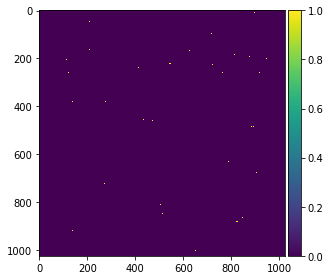

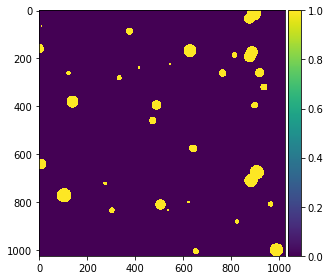

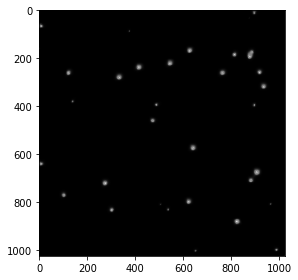

In [7]:
for x, y in gen_train(n_src=34, max_rad=30, max_n=30, shape=input_size, n_noise=10000):
    ans = model.predict(x)
    plt.figure(0)
    imshow(x[0, :, :, 0])
    plt.figure(1)
    imshow(y[0, :, :, 0])
    plt.figure(2)
    imshow(ans[0, :, :, 0])
    plt.show()
    break